# 07. Marketing Email Campaign

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [3]:
from platform import python_version
print(python_version())

3.6.10


In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Load Dataset


In [5]:
# read `email_table.csv
email_table = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/email/email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [6]:
# basic information
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [7]:
# check missing values
email_table.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [8]:
# read email_opened_table.csv
email_opened = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/email/email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [9]:
# basic information
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [10]:
# read link_clicked_table.csv
link_table = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/email/link_clicked_table.csv')
link_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [11]:
# basic information
link_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [12]:
# check uniqueness of email_id in three tables
print('email_table.csv:\t', len(email_table['email_id'].unique()))
print('email_opened_table.csv:\t', len(email_opened['email_id'].unique()))
print('link_clicked_table.csv:\t', len(link_table['email_id'].unique()))

email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


## Data Processing

In [13]:
# create new columns `opened` and `clicked`
email_opened['opened'] = 1
link_table['clicked'] = 1
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_table, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


## Question 1

In [14]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


## Question 2

In [15]:
data.groupby('clicked')['email_id'].count() / len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

In [16]:
data[['clicked','email_id']].groupby('clicked').count() / len(data)

,email_id
clicked,
0,0.97881
1,0.02119


Clearly, the data is highly imbalanced:

* $2.12\%$ of all the email is clicked.
* $97.88\%$ of all the email is not clicked.

The imbalance of the data is a major challange for similar problems.

##### Visualization of email_text

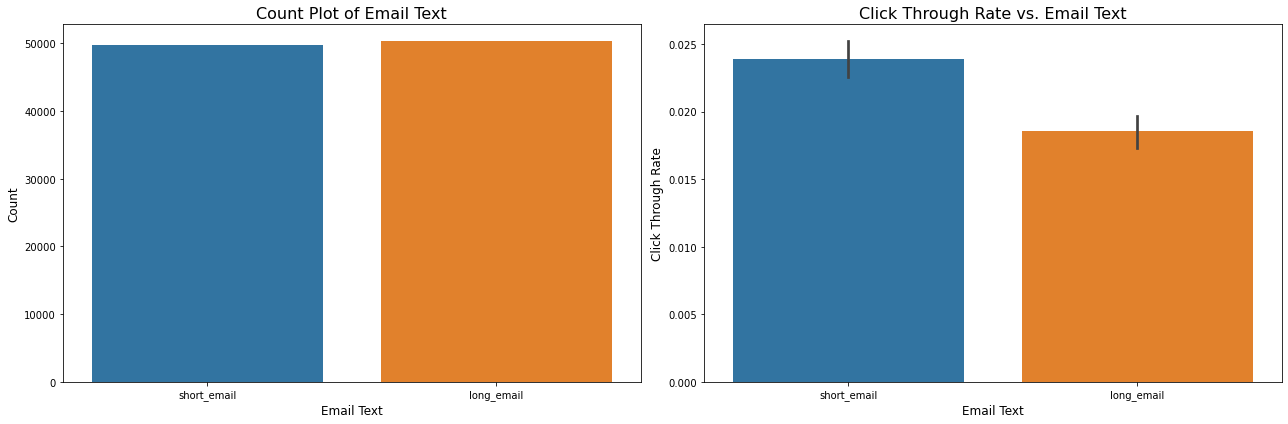

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

##### Visualization of email_version

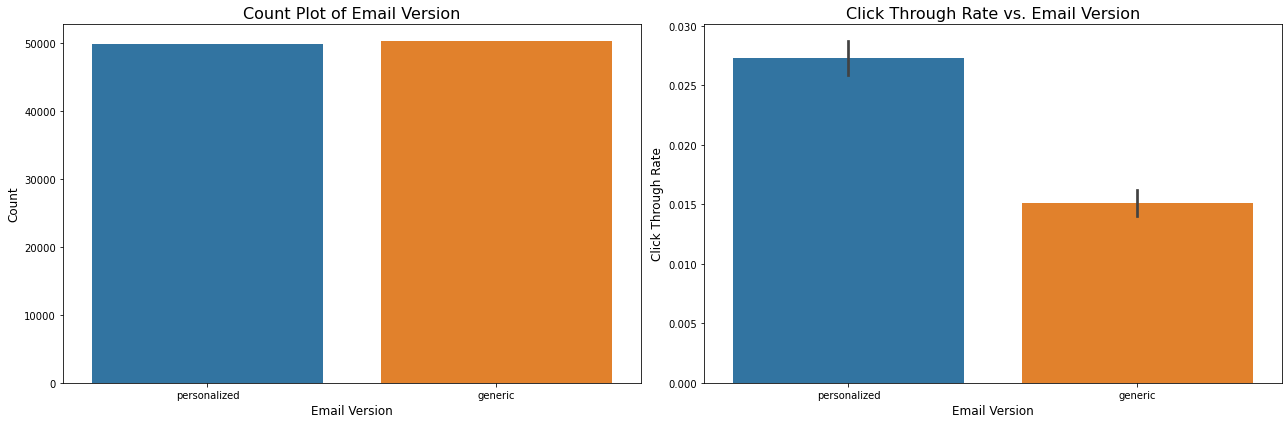

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

##### Visualization of hour

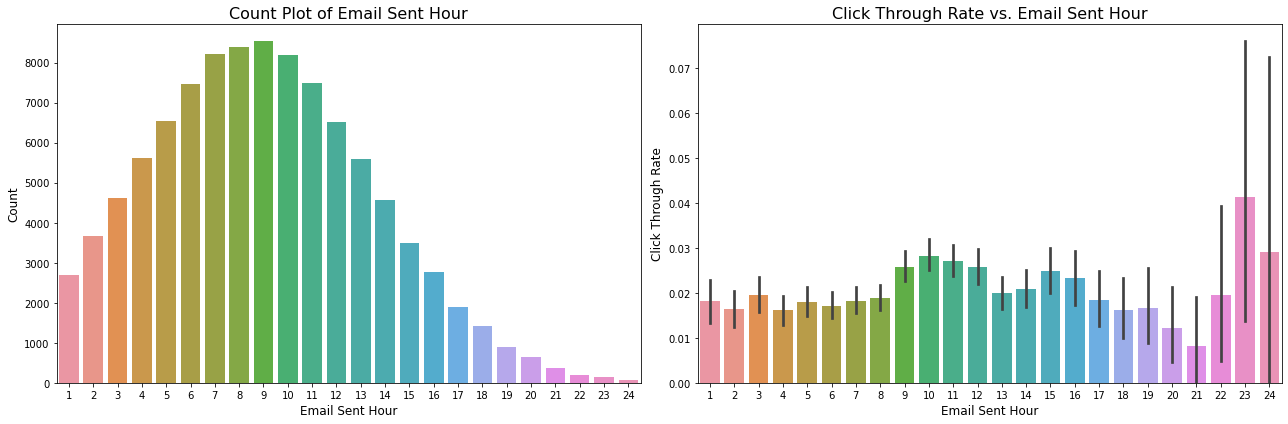

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

##### Visualization of weekday

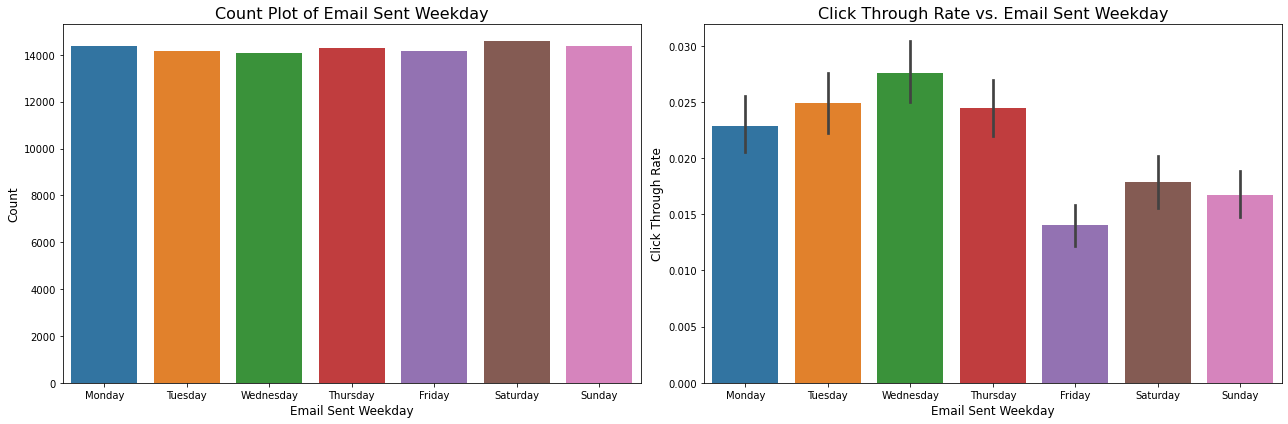

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

##### Visualization of user_country

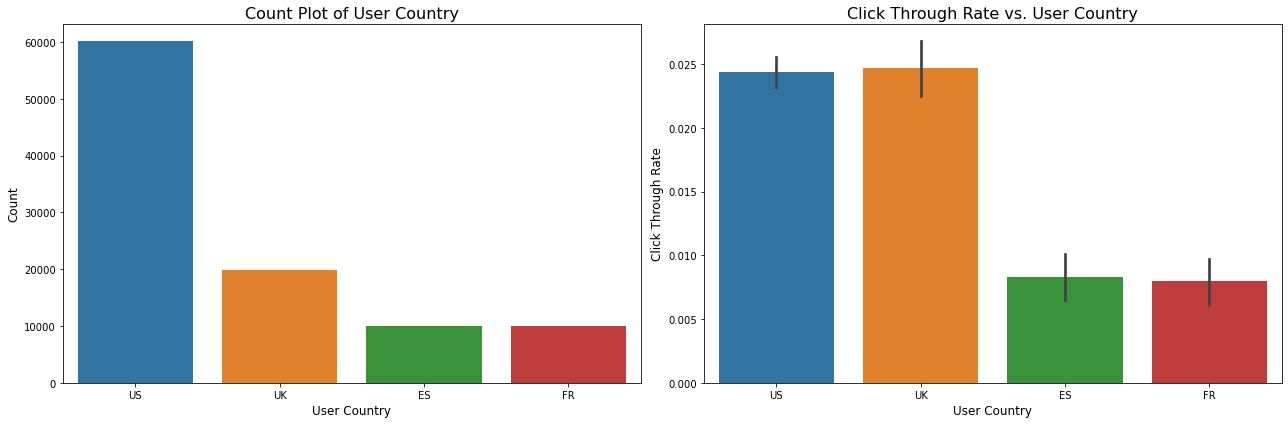

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

##### Visualization of user_past_purchases

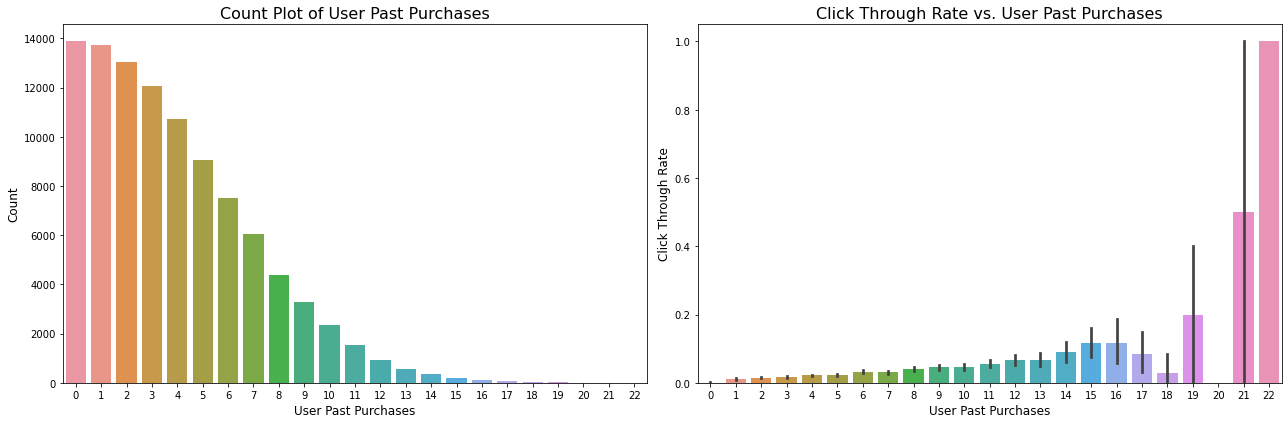

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

Clearly, different features have different influence on the user click-through-rate. Now, let's try to build some machine learning models to try to predict the click probability. In this notebook, I only implement the Random Forest model with the default parameter settings without advanced optimization, such as grid search and so on.

In [31]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.162-b12, mixed mode)
  Starting server from D:\Anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DELL\AppData\Local\Temp\tmpnqqsue27
  JVM stdout: C:\Users\DELL\AppData\Local\Temp\tmpnqqsue27\h2o_ALEX_started_from_python.out
  JVM stderr: C:\Users\DELL\AppData\Local\Temp\tmpnqqsue27\h2o_ALEX_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,5 months and 7 days !!!
H2O_cluster_name:,H2O_from_python_ALEX_32bw0j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [32]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
type,int,enum,enum,int,enum,enum,int,int,enum
mins,8.0,,,1.0,,,0.0,0.0,
mean,498690.1961600002,,,9.059299999999906,,,3.8784500000000244,0.10345,
maxs,999998.0,,,24.0,,,22.0,1.0,
sigma,289230.7275342946,,,4.439637441706914,,,3.196109783577138,0.3045472459081676,
zeros,0,,,0,,,13877,89655,
missing,0,0,0,0,0,0,0,0,0
0,718277.0,short_email,personalized,7.0,Friday,US,5.0,0.0,0
1,193657.0,long_email,generic,14.0,Friday,UK,6.0,0.0,0
2,378632.0,short_email,generic,10.0,Friday,US,1.0,0.0,0


In [33]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['clicked'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [34]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


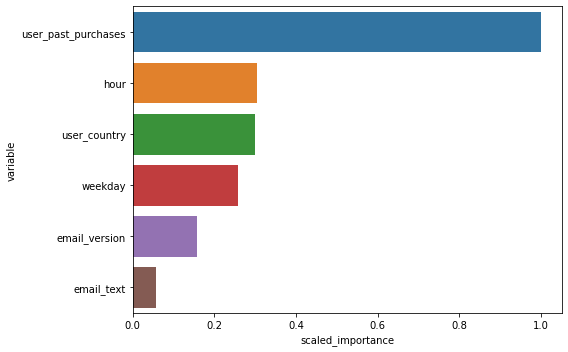

In [35]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [36]:
# Make predictions
train_true=train.as_data_frame()['clicked'].values # remove index, only keep values as array 
print(train_true)
test_true=test.as_data_frame()['clicked'].values
train_pred=model.predict(train).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1
test_pred=model.predict(test).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1

train_fpr,train_tpr,_=roc_curve(train_true,train_pred)
test_fpr,test_tpr,_=roc_curve(test_true,test_pred)
train_auc=np.round(auc(train_fpr,train_tpr),3)
test_auc=np.round(auc(test_fpr,test_tpr),3)

[0 0 0 ... 0 0 0]
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [37]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000



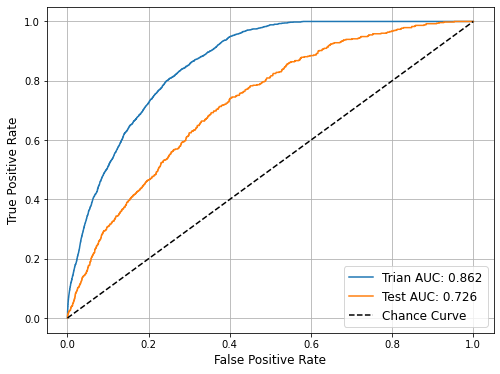

In [38]:
# ROC curves
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(train_fpr,train_tpr,label='Trian AUC: '+str(train_auc))
ax.plot(test_fpr,test_tpr,label='Test AUC: '+str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


D:\Anaconda3\envs\py36\lib\site-packages\h2o\model\model_base.py:1359: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


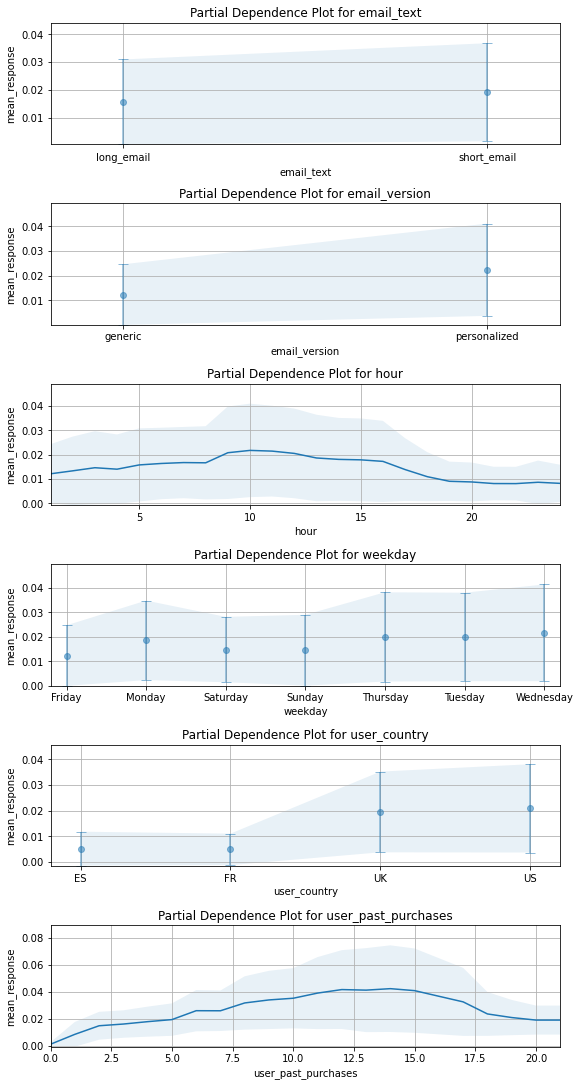

In [39]:
_ = model.partial_plot(train, cols=feature,nbins=200, figsize=(8, 15))

In [40]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8525 closed.


It seems that currently there are some overfitting, which could be solved with grid search.

## Question 3

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link.

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.

* Randomly assign users to two groups, Control group and Experiment group.
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

## Question 4

See visualization and partial dependence plot for details, which should be very clear.